# DATA PROJECT

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# import dst data loader
import pydst
Dst = pydst.Dst(lang='en') 


pd.set_option('display.max_rows', None)   # show all rows
pd.set_option('display.max_columns', None)   # show all columns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Importing data from Industrial Federation of Robotics:

In [57]:
# Data for industrial robots on industry, year for Denmark
filename = 'ifr_dk.csv'
df_ifr = pd.read_csv(filename, delimiter=';')

# Drop obs that are not relevant (data not valid before 2004)
drop = [str(year) for year in range(1993,2004)]
df_ifr.drop(drop, axis=1, inplace=True)
df_ifr = df_ifr.iloc[1:20, :]

# Renaming columns
col_dict = {}
for i in range(2004, 2016+1): 
    col_dict[str(i)] = f'year{i}' 
    df_ifr[str(i)] = df_ifr[str(i)].apply(str)
col_dict['DK'] = f'BRANCHE_IFR' 

# Omdøber kolonner
df_ifr.rename(columns=col_dict, inplace=True)

# Transponerer med melt
df_ifr_long = pd.melt(df_ifr, id_vars=['BRANCHE_IFR'], var_name='year', value_name='value')
df_ifr_long['year'] = df_ifr_long['year'].str.replace('year', '').astype(int)

df_ifr_long.head(20)


,BRANCHE_IFR,year,value
0,"A-B-Agriculture, forestry, fishing",2004,59
1,C-Mining and quarrying,2004,46
2,10-12-Food and beverages,2004,145
3,13-15-Textiles,2004,95
4,16-Wood and furniture,2004,262
5,17-18-Paper,2004,14
6,19-22-Plastic and chemical products,2004,295
7,"23-Glass, ceramics, stone, mineral products (n...",2004,0
8,24-Basic metals,2004,70
9,25-Metal products (non-automotive),2004,928


Importing data from Danmarks Statistik:

In [58]:
# Inspicerer indhold
nabb69_vars = Dst.get_variables(table_id='NABB69')
nabb69_vars.id.unique()

# Importing data from statistikbanken through an API
variables = {'SOCIO':['EMPM_DC'],'BRANCHE':['*'],'Tid':['2004','2005','2006','2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016']}

# Importerer data
nabb69 = Dst.get_data(table_id = 'NABB69', variables=variables)
nabb69.sort_values(by=['SOCIO', 'TID', 'BRANCHE'], inplace=True)

# Ordner industri-koder: Klar til merge med ifr
# Dictionary for oversættelse af industri-koder
industry = nabb69.BRANCHE
dict_nabb69    = {x[:5]: x[6:] for x in industry}
dict_crosswalk = {'01000':'A-B-Agriculture, forestry, fishing',
                  '02000':'A-B-Agriculture, forestry, fishing',
                  '03000':'A-B-Agriculture, forestry, fishing',
                  '06090':'C-Mining and quarrying',
                  '10120': '10-12-Food and beverages',
                  '13150':'13-15-Textiles',
                  '16000': '16-Wood and furniture',
                  '17000':'17-18-Paper',
                  '18000':'17-18-Paper',
                  '19000':'19-22-Plastic and chemical products',
                  '20000':'19-22-Plastic and chemical products',
                  '21000':'19-22-Plastic and chemical products',
                  '22000':'19-22-Plastic and chemical products',
                  '23000':'23-Glass, ceramics, stone, mineral products (n...',
                  '24000':'24-Basic metals',
                  '25000':'25-Metal products (non-automotive)',
                  '28000':'28-Industrial machinery',
                  '26000':'26-27-Electrical/electronics',
                  '27000':'26-27-Electrical/electronics',
                  '29000':'29-Automotive',
                  '30000':'30-Other vehicles',
                  '31320':'91-All other manufacturing branches',
                  '33000':'91-All other manufacturing branches',
                  '35000':'E-Electricity, gas, water supply',
                  '36000':'E-Electricity, gas, water supply',
                  '37390':'E-Electricity, gas, water supply',
                  '41430':'Construction',
                  '72002':'P-Education/research/development',
                  '85202':'P-Education/research/development'}

# Opdaterer dictionary så alle andre kategorier får '90'.
dict_crosswalk.update({
    str(key): '90-All other non-manufacturing branches'
    for key in range(0, 100000)
    if str(key) not in dict_crosswalk
})

# Tilføjer ny variabel med talkoder for branche og bruger dictionary til at oversætte industrikoder
nabb69['BRANCHE_K']   = nabb69['BRANCHE'].str[:5]
nabb69['BRANCHE_IFR'] = nabb69['BRANCHE_K'].map(dict_crosswalk)

# Aggregerer på IFR-industrier og tid
nabb69['emp_ifr'] = nabb69.groupby(['BRANCHE_IFR', 'TID'])['INDHOLD'].transform(sum)

nabb69 = nabb69[nabb69['BRANCHE_K'].str.isnumeric()]

# Beholder kun subset: relevante obs og variable
nabb69 = nabb69.loc[:, ['TID', 'BRANCHE_IFR', 'emp_ifr']]
nabb69 = nabb69.drop_duplicates(subset=['BRANCHE_IFR', 'TID'])
nabb69.rename(columns={'TID': 'year'}, inplace=True)

nabb69.head(10)


,year,BRANCHE_IFR,emp_ifr
783,2004,"A-B-Agriculture, forestry, fishing",79857.0
786,2004,C-Mining and quarrying,3492.0
787,2004,10-12-Food and beverages,69960.0
788,2004,13-15-Textiles,9995.0
789,2004,16-Wood and furniture,12614.0
790,2004,17-18-Paper,20198.0
792,2004,19-22-Plastic and chemical products,46831.0
796,2004,"23-Glass, ceramics, stone, mineral products (n...",15200.0
797,2004,24-Basic metals,5520.0
798,2004,25-Metal products (non-automotive),38487.0


# Analysis

First part: Descriptive statistics

Gør data klar til plot

In [59]:
# Merger datasæt på IFR og year
ifr_nabb69 = pd.merge(df_ifr_long, nabb69, on=['BRANCHE_IFR', 'year'], how='left')
ifr_nabb69.value = ifr_nabb69.value.astype(float)

# Laver dictionary med pænerer værdier på IFR-navne til legends
dict_legend = {
    'A-B-Agriculture, forestry, fishing': 'Agriculture, forestry, fishing',
    'C-Mining and quarrying': 'Mining and quarrying',
    '10-12-Food and beverages': 'Food and beverages',
    '13-15-Textiles': 'Textiles',
    '16-Wood and furniture': 'Wood and furniture',
    '17-18-Paper': 'Paper',
    '19-22-Plastic and chemical products': 'Plastic and chemical products',
    '23-Glass, ceramics, stone, mineral products (n...': 'Glass, ceramics, stone, mineral products',
    '24-Basic metals': 'Basic metals',
    '25-Metal products (non-automotive)': 'Metal products (non-automotive)',
    '26-27-Electrical/electronics': 'Electrical/electronics',
    '28-Industrial machinery': 'Industrial machinery',
    '29-Automotive': 'Automotive',
    '30-Other vehicles': 'Other vehicles',
    '91-All other manufacturing branches': 'All other manufacturing branches',
    'E-Electricity, gas, water supply': 'Electricity, gas, water supply',
    'Construction': 'Construction',
    'P-Education/research/development': 'Education/research/development'
}
ifr_nabb69['ifr_legend'] = ifr_nabb69['BRANCHE_IFR'].map(dict_legend)

# Udregner robost pr. ths. worker (relativt mål for robot-intensiteten i en industri)
ifr_nabb69['rob_pr_ths'] = ifr_nabb69.value/ifr_nabb69.emp_ifr
ifr_nabb69 = ifr_nabb69.dropna()

# Udregner mean pr. år på tværs af industrier
rob_pr_ths_mean      = ifr_nabb69.groupby(['year'])['rob_pr_ths'].mean()
ifr_nabb69           = pd.merge(ifr_nabb69, rob_pr_ths_mean, on=['year'], how='left')

# Renamer kolonner
ifr_nabb69.rename(columns={'rob_pr_ths_x': 'rob_pr_ths',
                           'rob_pr_ths_y': 'rob_pr_ths_y_mean'}, inplace=True)

ifr_nabb69.head(10)

,BRANCHE_IFR,year,value,emp_ifr,ifr_legend,rob_pr_ths,rob_pr_ths_y_mean
0,"A-B-Agriculture, forestry, fishing",2004,59.0,79857.0,"Agriculture, forestry, fishing",0.000739,0.006274
1,C-Mining and quarrying,2004,46.0,3492.0,Mining and quarrying,0.013173,0.006274
2,10-12-Food and beverages,2004,145.0,69960.0,Food and beverages,0.002073,0.006274
3,13-15-Textiles,2004,95.0,9995.0,Textiles,0.009505,0.006274
4,16-Wood and furniture,2004,262.0,12614.0,Wood and furniture,0.020771,0.006274
5,17-18-Paper,2004,14.0,20198.0,Paper,0.000693,0.006274
6,19-22-Plastic and chemical products,2004,295.0,46831.0,Plastic and chemical products,0.006299,0.006274
7,24-Basic metals,2004,70.0,5520.0,Basic metals,0.012681,0.006274
8,25-Metal products (non-automotive),2004,928.0,38487.0,Metal products (non-automotive),0.024112,0.006274
9,28-Industrial machinery,2004,7.0,63927.0,Industrial machinery,0.000109,0.006274


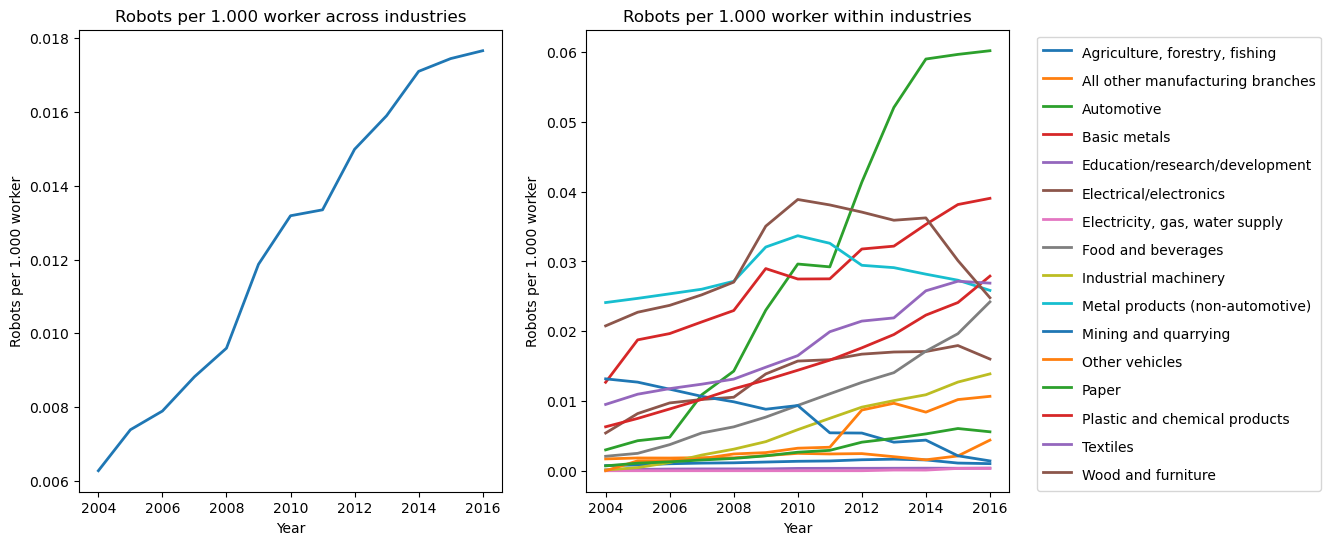

In [63]:
# Plotter
def plot_rob_pr_ths():
    plot = plt.figure(figsize=(12,6))

    # a. create line plot for aggregate development in robots across industries
    ax = plot.add_subplot(1,2,1)

    ax.plot(ifr_nabb69.year, ifr_nabb69.rob_pr_ths_y_mean, label=None, marker=None, linestyle='-', linewidth=2)
    #x_pos = ifr_nabb69.year.iloc[-1] + 0.2
    #y_pos = ifr_nabb69.rob_pr_ths_y_mean.iloc[-1]
    
    ax.set_title(f'Robots per 1.000 worker across industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')

    # b. plot for each industry
    ax = plot.add_subplot(1,2,2)

    for industry, data in ifr_nabb69.groupby('ifr_legend'):
        #ax.plot(data.year, data.rob_pr_ths, label=None, marker=None, linestyle='-', linewidth=2)
        ax.plot(data.year, data.rob_pr_ths, label=industry, marker=None, linestyle='-', linewidth=2)
        #x_pos = data.year.iloc[-1] + 0.2
        #y_pos = data.rob_pr_ths.iloc[-1]
        #ax.annotate(industry, xy=(x_pos, y_pos), ha='left', va='center')

    ax.set_title(f'Robots per 1.000 worker within industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), handleheight=1.97)

plot_rob_pr_ths()  

In [65]:
# Importing NP25: Enhed for alle værdier er årlig vækstrate i pct.
np25_vars = Dst.get_variables(table_id='NP25')
np25_vars.id.unique()

# Importing data from statistikbanken through an API
variables = {'BRANCHE':['*'],'TYPE':['LP', 'IT', 'AK', 'LQ', 'TF'],'PRISENHED':['VPR_V'],'Tid':['2004','2005','2006','2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016']}

# Importerer udvalgt subset af data
np25 = Dst.get_data(table_id = 'NP25', variables=variables)
np25.sort_values(by=['TYPE', 'TID', 'BRANCHE'], inplace=True)

# Create binary mask with trues where digit values in the 'BRANCHE_K' column
np25.loc[:, 'BRANCHE_K'] = np25['BRANCHE'].str[:5]
mask = np25['BRANCHE_K'].str.isdigit()

# Select only the rows that meet the condition
np25 = np25.loc[mask, :]

# Tilføjer ny variabel med talkoder for branche og bruger dictionary til at oversætte industrikoder
np25['BRANCHE_IFR'] = np25['BRANCHE_K'].map(dict_crosswalk)


# Transponerer med melt
# pivot dataframe
np25 = np25.pivot(index=['BRANCHE', 'PRISENHED', 'TID', 'BRANCHE_K', 'BRANCHE_IFR'], columns='TYPE', values='INDHOLD').reset_index()

# rename columns
np25.columns.name = None
np25 = np25.rename(columns={
    '01000 Agriculture and horticulture': 'BRANCHE',
    'Annual growth rate in per cent': 'PRISENHED',
    'A-B-Agriculture, forestry, fishing': 'BRANCHE_IFR'
})

# Convert to float
prod_var = ['Educational level', 'It-Capital deepening', 'Labour productivity', 'Non IT-capital deepening', 'Total factor productivity']
np25[prod_var] = np25[prod_var].applymap(lambda x: np.nan if x == '..' else float(x))

# Aggregerer på IFR-industrier og tid
np25 = np25.groupby(['BRANCHE_IFR', 'TID']).agg({
    'Educational level': 'sum',
    'It-Capital deepening': 'sum',
    'Labour productivity': 'sum',
    'Non IT-capital deepening': 'sum',
    'Total factor productivity': 'sum'
}).reset_index

# Renamer kolonne
#np25.rename(columns={'TID': 'year'}, inplace=True)

# Stadig 19 industrier
print(np25['BRANCHE_IFR'].nunique())

TypeError: 'method' object is not subscriptable

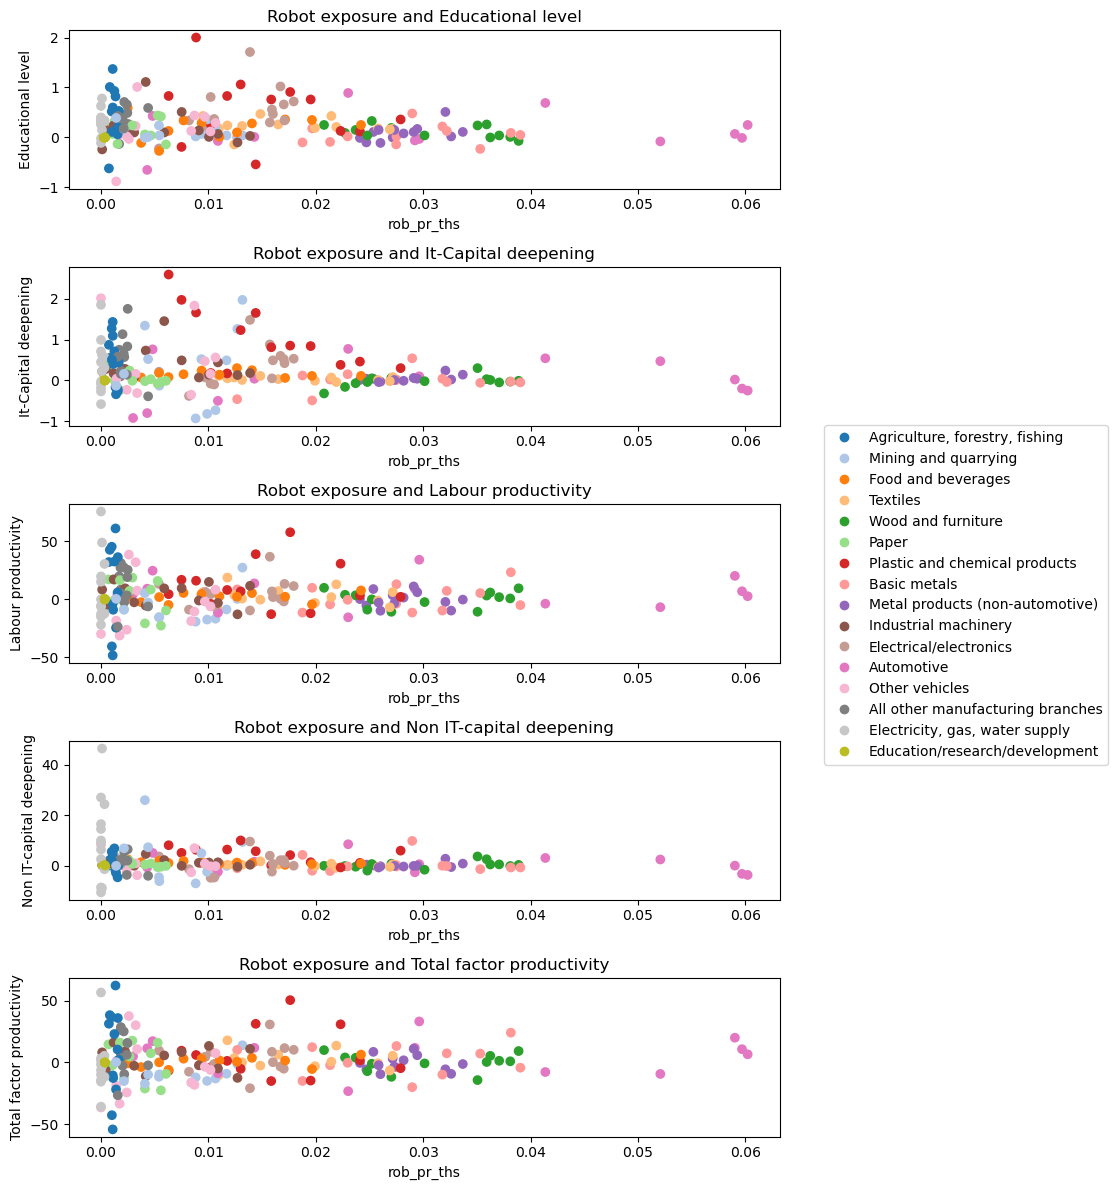

In [ ]:
# Merger NP25 på eksisterende data på IFR-industrier og tid
ifr_nabb69_np25 = pd.merge(ifr_nabb69, np25, on=['BRANCHE_IFR', 'year'], how='left')

# Laver scatterplot for de 5 productivitetsmål:
# Colormap
cmap = plt.cm.get_cmap('tab20', 19)
industry_labels = ifr_nabb69_np25['ifr_legend'].unique()
industry_colors = [cmap(i) for i in range(len(industry_labels))]
color_dict = dict(zip(industry_labels, industry_colors))

# Assign a color to each data point based on its industry
colors = [color_dict[label] for label in ifr_nabb69_np25['ifr_legend']]

fig, axes = plt.subplots(nrows=5, figsize=(8, 12))

# Loop through each subplot and plot the corresponding y-variable
for i, ax in enumerate(axes):
    ax.scatter(ifr_nabb69_np25.rob_pr_ths, ifr_nabb69_np25[prod_var[i]], c=colors)
    ax.set_xlabel('rob_pr_ths')
    ax.set_ylabel(prod_var[i])
    ax.set_title(f'Robot exposure and {prod_var[i]}')


# Create a legend object
handles = [plt.plot([], [], marker="o", ls="", color=color_dict[label], label=label)[0] for label in industry_labels]
plt.subplots_adjust(right=88) # adjust the right margin to make room for the legend
fig.legend(handles, industry_labels, loc="center right", bbox_to_anchor=(1.4, 0.5))

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Udregner mean på år for hvert produktivitetsmål (industrier kollapses)

ifr_nabb69_np25 = ifr_nabb69_np25.sort_values(by=['year']).reset_index(drop=True, inplace=True)
#ifr_nabb69_np25.reset_index(drop=True, inplace=True)

# Udregner mean pr. år på tværs af industrier: prod_var er en liste over relevante produktivitetsvariable
for var in prod_var:
    var_mean = ifr_nabb69_np25.groupby(['year'])[var].mean()
    # Rename column to assign _mean
    ifr_nabb69_np25[var + '_mean'] = ifr_nabb69_np25['year'].map(var_mean)

ifr_nabb69_np25['rob_pr_ths_y_mean_pct_change'] = ifr_nabb69_np25['rob_pr_ths_y_mean'].pct_change(periods=19) * 100


# calculate the lagged value of x
# ifr_nabb69_np25['x_lagged'] = ifr_nabb69_np25['x'].shift(1)

# # calculate the natural logarithm of x and x_lagged
# ifr_nabb69_np25['ln_x'] = np.log(ifr_nabb69_np25['x'])
# ifr_nabb69_np25['ln_x_lagged'] = np.log(ifr_nabb69_np25['x_lagged'])

# # calculate ln(x) - ln(x-1)
# ifr_nabb69_np25['ln_x_diff'] = ifr_nabb69_np25['ln_x'] - ifr_nabb69_np25['ln_x_lagged']

# ifr_nabb69_np25['D_rob_pr_ths'] = ifr_nabb69_np25.groupby('year')['rob_pr_ths_y_mean'].pct_change()


# Calculate yearly percentage change in rob_pr_ths to compare with yearly change in productivity
# for i in list(ifr_nabb69_np25.year):
#     ifr_nabb69_np25['D_rob_pr_ths'] = ifr_nabb69_np25.groupby('year')['rob_pr_ths'].pct_change()

#ifr_nabb69_np25['D_rob_pr_ths'] = ifr_nabb69_np25.groupby('year')['rob_pr_ths'].pct_change()

# Access the cell using the .loc[] indexer
#cell_value = df.loc[row_index, col_name]

# Print the cell value
# widgets.interact(plot_func, 
#     # Let the widget interact with data through plot_func()    
# ); 

ifr_nabb69_np25.head(50)


,level_0,index,BRANCHE_IFR,year,value,emp_ifr,ifr_legend,rob_pr_ths,rob_pr_ths_y_mean,Educational level,It-Capital deepening,Labour productivity,Non IT-capital deepening,Total factor productivity,Educational level_mean,It-Capital deepening_mean,Labour productivity_mean,Non IT-capital deepening_mean,Total factor productivity_mean,D_rob_pr_ths,rob_pr_ths_y_mean_pct_change
0,0,0,"A-B-Agriculture, forestry, fishing",2004,59.0,79857.0,"Agriculture, forestry, fishing",0.000739,0.006274,-0.62,0.87,31.98,-0.02,31.35,0.090625,0.551250,8.956250,2.905000,5.466875,NaN,NaN
1,15,11,29-Automotive,2004,17.0,5689.0,Automotive,0.002988,0.006274,0.13,-0.92,4.46,0.31,4.88,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
2,14,7,24-Basic metals,2004,70.0,5520.0,Basic metals,0.012681,0.006274,0.01,-0.46,8.50,-1.07,10.13,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
3,13,1,C-Mining and quarrying,2004,46.0,3492.0,Mining and quarrying,0.013173,0.006274,0.04,1.97,27.18,9.36,13.90,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
4,12,2,10-12-Food and beverages,2004,145.0,69960.0,Food and beverages,0.002073,0.006274,0.12,0.28,7.47,1.65,5.31,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
5,10,5,17-18-Paper,2004,14.0,20198.0,Paper,0.000693,0.006274,0.20,0.46,17.08,1.70,14.60,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
6,9,6,19-22-Plastic and chemical products,2004,295.0,46831.0,Plastic and chemical products,0.006299,0.006274,0.83,2.59,4.35,8.05,-6.75,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
7,8,12,30-Other vehicles,2004,0.0,4751.0,Other vehicles,0.000000,0.006274,0.30,2.01,-29.87,8.23,-36.57,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
8,11,3,13-15-Textiles,2004,95.0,9995.0,Textiles,0.009505,0.006274,0.43,0.16,6.10,1.35,4.08,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN
9,6,9,28-Industrial machinery,2004,7.0,63927.0,Industrial machinery,0.000109,0.006274,-0.24,0.22,8.28,0.14,8.14,0.090625,0.551250,8.956250,2.905000,5.466875,0.0,NaN


Explain what you see when moving elements of the interactive plot around. 

Second part: Correlation and regression analysis

# Conclusion

ADD CONCISE CONLUSION.